In [ ]:
!unzip trainingSample.zip

In [ ]:
!unzip colorized-MNIST-Updated.zip

In [ ]:
import cv2
#globbing utility.
import glob
import torchvision.transforms as transforms




def dataProcess(filename,img_type):
  mainList_train = []

  for i in range(10):
    path = filename+'/'+str(i)+"/"+'*.'+img_type
    print(path)
    path = glob.glob(path)

    print(path)

    for file in path:
      
    # Read the image
        image = cv2.imread(file)
      
        # Convert BGR image to RGB image

        
        # Define a transform to convert
        # the image to torch tensor
        transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ])
        
        # Convert the image to Torch tensor
        tensor = transform(image)

        
        

        summ = tensor[0]+tensor[1]+tensor[2]

        mainList_train.append((summ,i))

        
    

  return mainList_train

colored_train = dataProcess('/content/colorized-MNIST-Updated/training',"png")

colored_test = dataProcess('/content/colorized-MNIST-Updated/testing',"png")

normal_data = dataProcess('/content/trainingSample',"jpg")
      
    
 

In [ ]:
import random

random.shuffle(normal_data)

random.shuffle(colored_train)

random.shuffle(colored_test)


total = colored_train+colored_test


train_len = int(len(total)*0.7)

color_train = total[0:train_len]
color_test = total[train_len:]

train_len = int(len(normal_data)*0.7)
normal_train = normal_data[0:train_len]
normal_test = normal_data[train_len:]


In [ ]:
print(len(normal_train))
print(len(normal_test))
print(len(color_train))
print(len(color_test))

29399
12601
26369
11301


In [ ]:
train_all = normal_train + color_train

In [ ]:
test_all = normal_test + color_test

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist


class BorisNet(nn.Module):
    def __init__(self):
        super(BorisNet, self).__init__()
        self.fc = nn.Linear(784, 10, bias=False)

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))


class BorisConvNet(nn.Module):
    def __init__(self):
        super(BorisConvNet, self).__init__()
        self.conv = nn.Conv2d(64, 10, 28, stride=1, padding=14)
        self.fc = nn.Linear(4 * 4, 10, bias=False)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 7)
        return self.fc(x.view(x.size(0), -1))

class BorisGraphNet(nn.Module):
    def __init__(self, img_size=28, pred_edge=False):
        super(BorisGraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = img_size ** 2
        self.fc = nn.Linear(N, 10, bias=False)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            #coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]])
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            # precompute adjacency matrix before training
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)


    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)  
        sigma = 0.05 * np.pi
        
        # Below, I forgot to square dist to make it a Gaussian (not sure how important it can be for final results)
        A = np.exp(- dist / sigma ** 2)
        print('WARNING: try squaring the dist to make it a Gaussian')
            
        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        print(A_hat[:10, :10])
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                 x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)


def train(log_interval,model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader,epoch):
    model.eval()
    test_loss = 0
    correct = 0

    prediction = []
    trueone= []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            prediction+=output.argmax(dim=1).cpu()

            #print(len(prediction))

            
            trueone+=target.cpu()
            #print(len(trueone))

    test_loss /= len(test_loader.dataset)


    if(epoch <= 150 ):

      print(
          '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))
      
      print('F1_score: %.3f' % f1_score(trueone, prediction,average='micro'))








batch_size=64
test_batch_size=1000
epochs = 10
lr = 0.001
pred_edge = True
seed=1
log_interval=200

use_cuda = True

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(normal_train,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(normal_test,
    batch_size=test_batch_size, shuffle=False)


#model = BorisNet()

model = BorisGraphNet(pred_edge=pred_edge)

#model = BorisConvNet()

model.to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-1 if model == 'conv' else 1e-4)
print('number of trainable parameters: %d' %
      np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

for epoch in range(1, epochs + 1):
    print("normal data testing")
    train(log_interval,model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader,epoch)

     


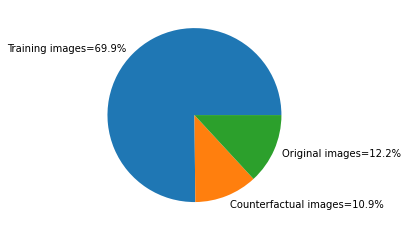

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([69.9, 10.9, 12.2])
mylabels = ["Training images=69.9%",  "Counterfactual images=10.9%", "Original images=12.2%"]

plt.pie(y, labels = mylabels)

#plt.ylabel(fontsize = 30, fontweight = 'bold')
plt.savefig("pi.PNG",fontsize = 30,bbox_inches = "tight")